In [10]:
import os
import sys
import logging
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Dict, Any, List, Generator

In [11]:
# package imports
from vsim import electorate, candidates, simulation, voting_system

# Electorate

We represent our electorate as an (m,n) dimensional matrix where m corresponds to each individual voter, and n corresponds to their opinion or preference of a given topic. Topics are not actually real and should be seen a simplification of randomly generating voter preferences in a way we can easily control and adjust. To ensure we can the effect of different underlying electorate dynamics (e.g. polarisation), we can generate electorates with different skews and biases. Below is a sample in a 2D dimensional case (each voter has a unique preference on two issues) for highly homogenous clusters and heteregenous clusters.

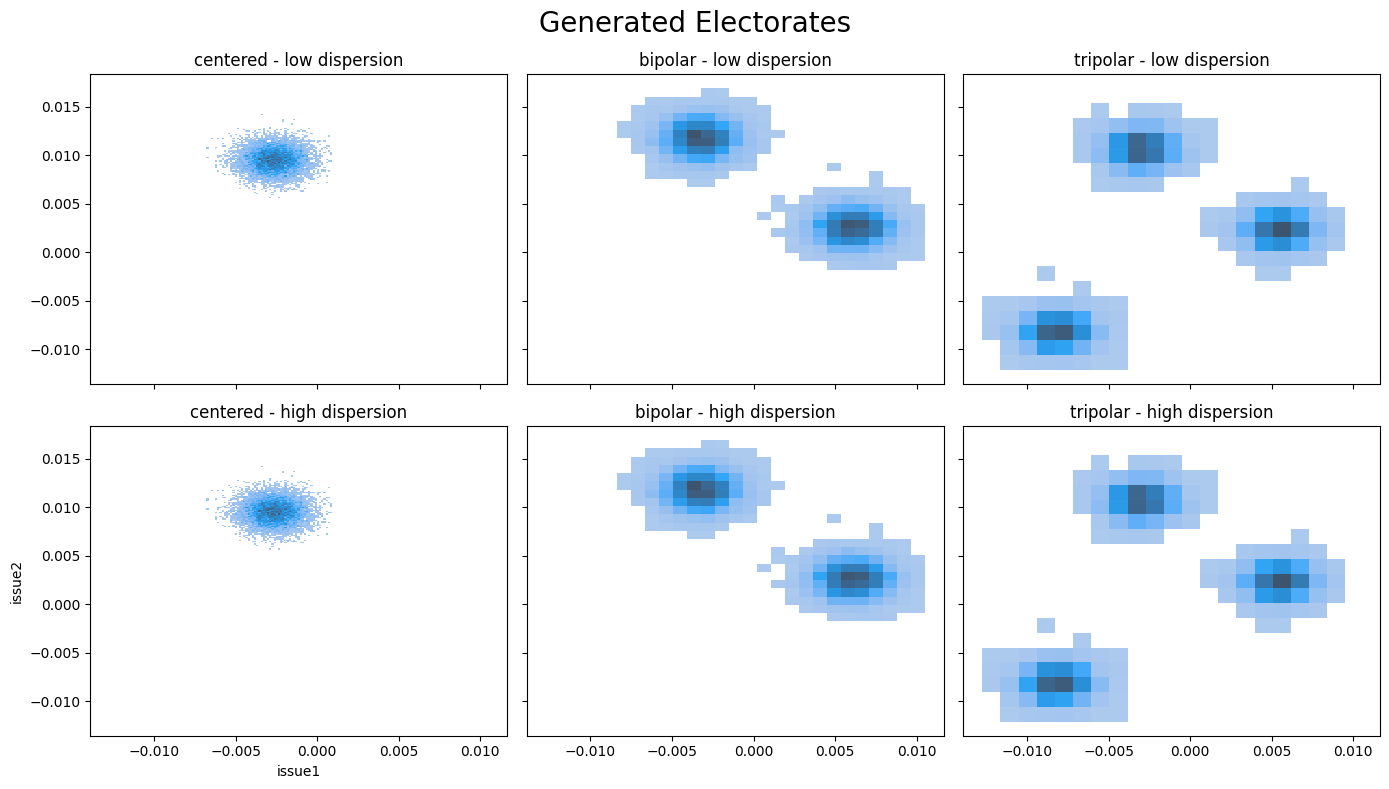

In [12]:
# params for generation; note that given O(n^2) for NN search, it is recommended to note over do population size.
SEED = 42
ISSUES = 2
POPULATION_SIZE = 10_000

centered = electorate.setup_electorate(POPULATION_SIZE, ISSUES, scenario="centered", seed=SEED)
bipolar = electorate.setup_electorate(POPULATION_SIZE, ISSUES, scenario="bipolar", seed=SEED)
tripolar = electorate.setup_electorate(POPULATION_SIZE, ISSUES, scenario="tripolar", seed=SEED)

# same but increase diversity of intra-cluster opinion; parameterised homogenity of opinion
CLUSTER_STD = 3.5
centered_wide = electorate.setup_electorate(POPULATION_SIZE, ISSUES, scenario="centered", seed=SEED, cluster_std=CLUSTER_STD)
bipolar_wide = electorate.setup_electorate(POPULATION_SIZE, ISSUES, scenario="bipolar", seed=SEED, cluster_std=CLUSTER_STD)
tripolar_wide = electorate.setup_electorate(POPULATION_SIZE, ISSUES, scenario="tripolar", seed=SEED, cluster_std=CLUSTER_STD)

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, sharey=True, sharex=True, tight_layout=True, figsize=(14, 8))

# normal
sns.histplot(x=centered[:, 0], y=centered[:, 1], ax=ax1, label="voter")
ax1.set_title("centered - low dispersion")

sns.histplot(x=bipolar[:, 0], y=bipolar[:, 1], ax=ax2, label="voter")        
ax2.set_title("bipolar - low dispersion")

sns.histplot(x=tripolar[:, 0], y=tripolar[:, 1], ax=ax3, label="voter")
ax3.set_title("tripolar - low dispersion")

# increased dispersion
sns.histplot(x=centered_wide[:, 0], y=centered_wide[:, 1], ax=ax4, label="voter")
ax4.set_title("centered - high dispersion")
ax4.set_xlabel("issue1")
ax4.set_ylabel("issue2")

sns.histplot(x=bipolar_wide[:, 0], y=bipolar_wide[:, 1], ax=ax5, label="voter")        
ax5.set_title("bipolar - high dispersion")

sns.histplot(x=tripolar_wide[:, 0], y=tripolar_wide[:, 1], ax=ax6, label="voter")
ax6.set_title("tripolar - high dispersion")

fig.suptitle("Generated Electorates", fontsize=20)
plt.show()

NOTE: that our candidate preference ranges are normalised to ensure we can compare distances in a reliable way despite introducing arbitrary skewing. 

# Simulating candidates and elections

The electorate (the people) vote for candidates. Candidates can be individuals or collection of individuals (i.e. a party) but ultimately represent a given pallete of opinions. Similarly to voters, this is represented by a (m, n) matrix, where each row m corresponds to candidate m opinion on issue n.

We assume that candidates align themselves with general electorate as they want to be elected. As such, the candidate positioning on issues is a function of the electorates underlying values. Systematically, we emulate this via clustering (KMeans in our case).

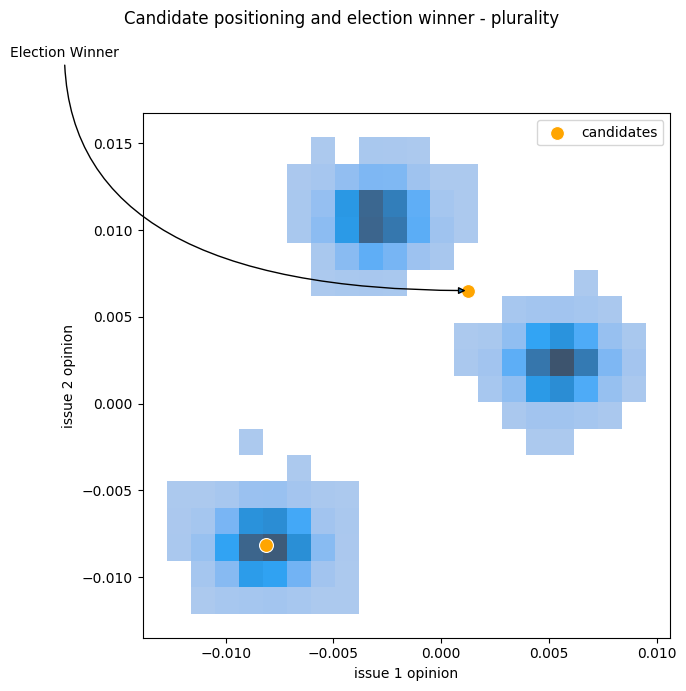

In [13]:
parties = candidates.setup_candidates(candidates=2, electorate=tripolar_wide, scenario="default")
result = voting_system.NaivePlurality({}).elect(candidates=parties, electorate=tripolar_wide)
winner = list(result.winners)[0]

fig, ax1 = plt.subplots(1,1, sharey=True, sharex=True, tight_layout=True, figsize=(7, 7))
sns.histplot(x=tripolar_wide[:,0], y=tripolar_wide[:,1], ax=ax1)
sns.scatterplot(x=parties[:,0], y=parties[:,1], label="candidates", ax=ax1, s=100, color="orange")
ax1.set_xlabel("issue 1 opinion")
ax1.set_ylabel("issue 2 opinion")
fig.suptitle("Candidate positioning and election winner - plurality")

arrow_props = {
    "arrowstyle": "-|>",
    "connectionstyle": "angle3",
    "lw": 1,
}

# annotate the winner of the election
plt.annotate("Election Winner", parties[winner, :], xytext=[-0.02, 0.02], xycoords='data', arrowprops=arrow_props)
plt.show()

# Measuring fairness - Pluralism vs. Majority

Fairness is not well defined, even within the political science literature, but to ensure we can adequately compare different systems in a simulated setting, we have opted for a simple metric, namely the average distance from the winner(s) of the election. This average is calculated over every voter, taking the euclidian distance to the winner (or winners) of the election. If there are multiple equally weighted winners, the distance is averaged across winners. In the simple case of pluralism and majority in a non-proportional system, commonly observed in elections of the executive branch in Rebublics (simplified U.S. case without electoral votes but still). 

Pluralism is defined as the winner is the one with the most votes. Majority on the other hand requires that a givne candidate meets a threshold of 50% of the vote to be crowned winner, otherwise the election is repeated. Typically, there is a reduction in the candidate pool to ensure the elections converge on a winner; we follow suit and reduce the candidate pool by 1, removing the lowest performing candidate at each round where a definte majority cannot be crowned.

Below both are illustrated and constrated with respect to our fairness metric.

NOTE: a full run of experiments take a significant amount of time (~1h depending on your system and parameter selection). Don't run things you don't need to, and check the /data directory for cached data.

In [44]:
# investigate fairness of majority and plurality under different circumstances
import itertools
import pandas as pd
import numpy as np
import logging
from tqdm import tqdm
from typing import Dict, Any, List, Generator
from vsim import electorate, candidates, simulation, voting_system


def generate_experiment_matrix(experiments: Dict[str, List[Any]]):
    return (dict(zip(experiments, x)) for x in itertools.product(*experiments.values()))


columns=[
    "fairness", 
    "issues",
    "electorate_size",
    "clusters",
    "electorate_dispersion"
    "candidates",
    "electoral_system",
]

experiments = {
    "electorate_size": [10_000, 20_000],
    "clusters": np.arange(1, 2, 2),
    "cluster_std": np.linspace(1, 2, 2),
    "electoral_system": ["majority", "plurality"],
    "candidates": np.arange(2, 5),
    "issues": np.arange(2, 5, dtype=int),
}

columns = [*experiments.keys(), "fairness"]


records = []
experiment_matrix = list(generate_experiment_matrix(experiments))

for params in tqdm(experiment_matrix):
    
    # setup objects
    voters = electorate.setup_electorate(**params)
    parties = candidates.setup_candidates(**params, electorate=voters)
    system = voting_system.setup_voting_system(name=params["electoral_system"], **params)
    
    # simulate elections
    sim = simulation.VotingSimulator(electorate=voters, candidates=parties, system=system, log=logging.getLogger())
    
    result = sim.run()
    result_record = { "fairness": round(result.measured_fairness, 3), **params }
    result_record = {k: v for k, v in result_record.items() if k in columns}
    records.append(result_record)

100%|█| 72/72 [


In [45]:
results_df = pd.DataFrame.from_records(records)

In [46]:
results_df

,fairness,electorate_size,clusters,cluster_std,electoral_system,candidates,issues
0,0.153,10000,1,1.0,majority,2,2
1,0.220,10000,1,1.0,majority,2,3
2,0.248,10000,1,1.0,majority,2,4
3,0.204,10000,1,1.0,majority,3,2
4,0.158,10000,1,1.0,majority,3,3
...,...,...,...,...,...,...,...
67,0.384,20000,1,2.0,plurality,3,3
68,0.303,20000,1,2.0,plurality,3,4
69,0.390,20000,1,2.0,plurality,4,2
70,0.272,20000,1,2.0,plurality,4,3


# Investigation of fairness between majority and pluralism

In [47]:
# generate correlation matrices for both different systems
majority = results_df.electoral_system == "majority"
plurality = results_df.electoral_system == "plurality"

In [48]:
majority_subset = results_df[majority].drop(["electoral_system"], axis=1) 
plurality_subset = results_df[plurality].drop(["electoral_system"], axis=1)

In [49]:
# vector of correlation with fairness for both systems
majority_corr_record = dict(**majority_subset.corrwith(majority_subset.fairness), **{"electoral_system": "majority"})
plurality_corr_record = dict(**plurality_subset.corrwith(plurality_subset.fairness), **{"electoral_system": "plurality"})

In [50]:
majority_corr_record

{'fairness': 0.9999999999999999,
 'electorate_size': -0.08079437954556773,
 'clusters': nan,
 'cluster_std': 0.7535569173958196,
 'candidates': -0.12032162206432337,
 'issues': -0.16845027089005266,
 'electoral_system': 'majority'}

In [51]:
# compose to make plotting easier
corr_df = pd.DataFrame.from_records([majority_corr_record, plurality_corr_record]).drop(["clusters", "fairness"], axis=1)

In [52]:
corr_df

,electorate_size,cluster_std,candidates,issues,electoral_system
0,-0.080794,0.753557,-0.120322,-0.168450,majority
1,-0.030119,0.545598,0.040027,-0.170626,plurality


In [53]:
# convert to long to enable bar plot
long_corr_cols = ["measure", "value", "electoral_system"]
long_corr_df = pd.DataFrame(columns=long_corr_cols)

for system in ["majority", "plurality"]:
    for measure in corr_df.columns:    
        for value in corr_df[ corr_df.electoral_system == system ][measure]:
            row = pd.DataFrame.from_records([{ "measure": measure, "value": value, "electoral_system": system }])
            long_corr_df = pd.concat([long_corr_df, row])
        
long_corr_df = long_corr_df.reset_index().drop("index", axis=1).drop([4, 9], axis=0)

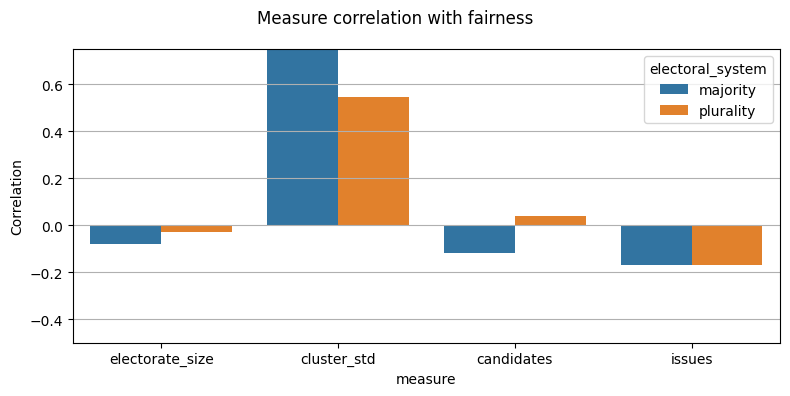

In [54]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 4), tight_layout=True)
sns.barplot(data=long_corr_df, x="measure", y="value", hue="electoral_system", ax=ax1)
ax1.set_ylim([-0.5, 0.75])
ax1.grid(axis="y")
ax1.set_ylabel("Correlation")
fig.suptitle("Measure correlation with fairness")
plt.show()